In [1]:
import pandas as pd
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

## Importation des données

In [2]:
df2 = pd.read_csv("Questionnaires.csv",sep=";")

In [3]:
df2.head()

,AGE,ID_NUM_TEL,SEXE,NIVEAU_SUPERIEUR_CHOIX,TYPE_TELEPHONE,ABONNEMENT_ILLIMITE,TEMPS_UTILISATION_SMS,ENVOI_SMS_SEMAINE,UTILISATION_T9,DESTINATAIRE_AMIS,DESTINATAIRE_COLLEGUES,DESTINATAIRE_FAMILLE,DESTINATAIRE_COMPAGNON,DUREE_LECTURE
0,16,202,Femme,lycee,classique,non,1 a 3,moins de 5,non,5,3,4,0,"4,19"
1,11,401,Homme,college,autre,oui,moins de 1,20 a 50,non,6,0,1,0,"5,24"
2,15,290,Homme,college,blackberry,non,1 a 3,plus de 100,oui,6,0,6,6,"3,14"
3,12,271,Homme,college,blackberry,oui,1 a 3,plus de 100,non,5,0,2,6,"1,05"
4,14,75,Femme,college,blackberry,oui,plus de 5,plus de 100,non,6,0,2,0,"6,29"


In [4]:
df = pd.read_csv("BDD_sms.csv",sep=";") # on a un pb d'encodage pour certaines lettres --'
df = df[df["SMS_ANON"].notna()]

In [5]:
df.head()

,NUM_SMS,ID_NUM_TEL,SMS_ANON
0,1,477,Hey ca va?\nAlors cette rentree?\nVa falloir s...
1,2,477,Ok super merci! Oui j'y comprends rien du tout...
2,3,477,Coucou !\nC'est quand la feria de Nimes?\nJ'su...
3,4,477,Coucou :)\nOui ca c'est bien passe!\nAlors je ...
4,5,477,On peut se rejoindre quelque part? Tu as cours...


## Merge des sms avec les données utilisateurs

In [6]:
df = df.merge(df2, how='left', on='ID_NUM_TEL') # On fusionne les deux dataframes par rapport à leur colonnes ID_NUM_TEL

## Création des corpus SEXE

In [7]:
corpus_sexe = df[["SMS_ANON","SEXE"]] # Selection des bonnes colonnes 
corpus_Femme=corpus_sexe.query("SEXE=='Femme'")
corpus_Homme=corpus_sexe.query("SEXE=='Homme'")


## Création des corpus AGE

In [8]:
from matplotlib import pyplot as plt
age = df["AGE"]
plt.hist(age)
plt.xlabel("Age")
plt.ylabel("Effectif")
plt.show()

<Figure size 640x480 with 1 Axes>

In [9]:
labels = [1,2,3,4,5] # Catégorie 
df["Agegroup"]=pd.qcut(df['AGE'], q=5, labels=labels) # On crée une nouvelle colonnes avec les catégories

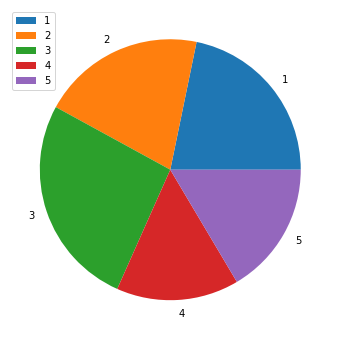

In [10]:
compte = df.groupby(["Agegroup"]).count() 
compte.plot.pie(y='ID_NUM_TEL', figsize=(6, 6)) 
plt.ylabel("")
plt.show()

In [11]:
corpus_age = df[["SMS_ANON","AGE","Agegroup"]] # Selection des bonnes colonnes 
corpus_age1=corpus_age.query('Agegroup==1')
corpus_age2=corpus_age.query('Agegroup==2')
corpus_age3=corpus_age.query('Agegroup==3')
corpus_age4=corpus_age.query('Agegroup==4')
corpus_age5=corpus_age.query('Agegroup==5')

# Comptage des mots

### Listes des stop words en français

In [12]:
stop_words = set(stopwords.words('French')) 

### Création d'un dataframe comptant les mots utilisés dans chaque corpus

In [13]:
vect = CountVectorizer(stop_words=stop_words) 


In [14]:
vect.fit(df["SMS_ANON"]) # Création du bag of word


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words={'ai', 'aie', 'aient', 'aies', 'ait', 'as', 'au',
                            'aura', 'aurai', 'auraient', 'aurais', 'aurait',
                            'auras', 'aurez', 'auriez', 'aurions', 'aurons',
                            'auront', 'aux', 'avaient', 'avais', 'avait',
                            'avec', 'avez', 'aviez', 'avions', 'avons', 'ayant',
                            'ayante', 'ayantes', ...},
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### Tokenization

In [15]:
F_word =  vect.transform(df[df["SEXE"]=='Femme']["SMS_ANON"]) # tokenisation des sms venant des femmes
H_word =  vect.transform(df[df["SEXE"]=='Homme']["SMS_ANON"]) # tokenisation des sms venant des hommes
age1_word =  vect.transform(df[df["Agegroup"]==1]["SMS_ANON"]) # tokenisation des sms venant du groupe d'âge N°1

### Comptage

In [19]:
### Tokenizationnb_F_word = F_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_F_word = F_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_H_word = H_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_age1_word = age1_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation


In [20]:
### Comptagedf_F = pd.DataFrame(nb_F_word, columns=vect.get_feature_names()) # création d'un dataframe regroupant le comptage pour femme
df_F = pd.DataFrame(nb_F_word, columns=vect.get_feature_names()) # création d'un dataframe regroupant le comptage pour homme
df_H = pd.DataFrame(nb_H_word, columns=vect.get_feature_names()) # création d'un dataframe regroupant le comptage pour homme
df_age1 = pd.DataFrame(nb_age1_word, columns=vect.get_feature_names()) # création d'un dataframe regroupant le comptage pour homme

### Création d'un dataFrame pour l'ensemble des sous-corpus

In [21]:
frames = [df_F,df_H,df_age1]
total_word = pd.concat(frames) # fusion des deux dataframes
total_word = total_word.reset_index(drop=True)
total_word=total_word.T
total_word = total_word.rename(columns={ total_word.columns[0]: "Femme",total_word.columns[1]: "Homme" ,total_word.columns[2]: "Age1" }) # renommage des colonnes

In [22]:
total_word.head(10)

,Femme,Homme,Age1
00,7,7,4
000,11,8,1
002,1,0,0
007,0,1,0
00h,6,0,0
00h00,2,3,3
00h15,1,0,0
00h20,1,0,0
00h26,1,0,0
00h30,1,0,0


In [25]:
total_word.to_csv("comptage_par_corpus.csv",index = True)


### Fréquence des occurences

In [34]:
totaux=total_word.sum(axis=0)


In [37]:
total_word["coeff_fem"] = total_word["Femme"] / totaux['Femme'] * 100
total_word["coeff_hom"] = total_word["Homme"] / totaux['Homme'] * 100
total_word["coeff_age1"] = total_word["Age1"] / totaux['Age1'] * 100

total_word.head()

,Femme,Homme,Age1,coeff_fem,coeff_hom,coeff_age1
00,7,7,4,0.001543,0.005325,0.004006
000,11,8,1,0.002425,0.006086,0.001002
002,1,0,0,0.000220,0.000000,0.000000
007,0,1,0,0.000000,0.000761,0.000000
00h,6,0,0,0.001323,0.000000,0.000000


### On peut maintenant afficher les mots les plus utilisés par une pop

In [38]:
total_word.sort_values("coeff_fem",ascending = False).head(10)

,Femme,Homme,Age1,coeff_fem,coeff_hom,coeff_age1
ça,6454,1171,1425,1.422667,0.890779,1.427198
oui,4909,1001,930,1.082100,0.761460,0.931434
si,4894,1426,1024,1.078793,1.084757,1.025579
va,4818,1321,898,1.062041,1.004884,0.899385
bien,4421,1284,757,0.974529,0.976738,0.758168
ca,4378,899,514,0.965051,0.683869,0.514793
fait,4246,873,936,0.935954,0.664090,0.937444
lol,4179,971,174,0.921185,0.738639,0.174268
non,3723,900,727,0.820668,0.684629,0.728121
plus,3566,981,798,0.786060,0.746246,0.799231


In [39]:
total_word.sort_values("coeff_hom",ascending = False).head(10)

,Femme,Homme,Age1,coeff_fem,coeff_hom,coeff_age1
si,4894,1426,1024,1.078793,1.084757,1.025579
va,4818,1321,898,1.062041,1.004884,0.899385
bien,4421,1284,757,0.974529,0.976738,0.758168
ça,6454,1171,1425,1.422667,0.890779,1.427198
oui,4909,1001,930,1.082100,0.761460,0.931434
plus,3566,981,798,0.786060,0.746246,0.799231
bon,3350,980,611,0.738447,0.745485,0.611942
lol,4179,971,174,0.921185,0.738639,0.174268
tout,2947,934,713,0.649613,0.710493,0.714100
non,3723,900,727,0.820668,0.684629,0.728121
